# TensorFlow Tutorial #01
# Simple Linear Model

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

## Introduction

Ce tutoriel illustre le workflow de base de l'utilisation de TensorFlow avec un modèle linéaire simple. Après avoir chargé le jeu de données MNIST avec des images de chiffres manuscrits, nous définissons et optimisons un modèle mathématique simple dans TensorFlow. Les résultats sont ensuite tracés et discutés.

Vous devriez être familier avec l'algèbre linéaire de base, Python et l'éditeur Jupyter Notebook. Cela aide également si vous avez une compréhension de base de l'apprentissage automatique et de la classification.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix

Ce tutoriel a été édité ave Python 3.5.2 (Anaconda) et TensorFlow version:

In [2]:
tf.__version__

'1.3.0'

## Load Data

L'ensemble de données MNIST est d'environ 12 Mo et sera téléchargé automatiquement s'il ne se trouve pas dans le chemin donné.

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("data/MNIST/", one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


L'ensemble de données MNIST a maintenant été chargé et comprend 70 000 images et étiquettes associées (c'est-à-dire des classifications des images). L'ensemble de données est divisé en trois sous-ensembles mutuellement exclusifs. Nous n'utiliserons que la formation et les tests dans ce tutoriel.

In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


### One-Hot Encoding

L'ensemble de données a été chargé en tant que codage dit "One-Hot". Cela signifie que les étiquettes ont été converties d'un seul nombre en un vecteur dont la longueur est égale au nombre de classes possibles. Tous les éléments du vecteur sont nuls sauf l'$i$ ème élément qui est un et signifie que la classe est $i$. Par exemple, les étiquettes codées One-Hot pour les 5 premières images de l'ensemble de test sont:

In [5]:
data.test.labels[0:5, :]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

Nous avons également besoin des classes en tant que nombres uniques pour diverses comparaisons et mesures de performance, donc nous convertissons les vecteurs codés One-Hot en un seul nombre en prenant l'indice de l'élément le plus élevé. Notez que le mot 'class' est un mot-clé utilisé en Python, nous devons donc utiliser le nom 'cls' à la place.

In [6]:
data.test.cls = np.array([label.argmax() for label in data.test.labels])

Nous pouvons maintenant voir la classe pour les cinq premières images de l'ensemble de tests. Comparez-les aux vecteurs codés One-Hot ci-dessus. Par exemple, la classe de la première image est 7, ce qui correspond à un vecteur codé One-Hot où tous les éléments sont à zéro, à l'exception de l'élément avec l'index 7.

In [7]:
data.test.cls[0:5]

array([7, 2, 1, 0, 4])

### Data dimensions

Les dimensions des données sont utilisées à plusieurs endroits dans le code source ci-dessous. En programmation informatique, il est généralement préférable d'utiliser des variables et des constantes plutôt que d'avoir à coder en dur des nombres spécifiques chaque fois que ce nombre est utilisé. Cela signifie que les numéros doivent seulement être changés en un seul endroit. Idéalement, ceux-ci seraient déduits des données qui ont été lues, mais ici, nous écrivons simplement les chiffres.

In [8]:
# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of classes, one class for each of 10 digits.
num_classes = 10

### Helper-function for plotting images

Fonction utilisée pour tracer 9 images dans une grille 3x3, et écrire les classes vraies et prédites sous chaque image.

In [9]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

### Plot a few images to see if data is correct

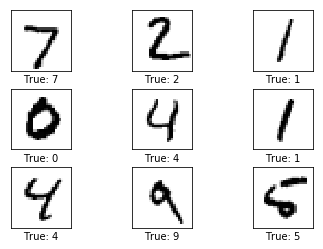

In [10]:
# Get the first images from the test-set.
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

## TensorFlow Graph

-Le but de TensorFlow est d'avoir un graphe dit de calcul qui peut être exécuté beaucoup plus efficacement que si les mêmes calculs devaient être effectués directement en Python. TensorFlow peut être plus efficace que NumPy parce que TensorFlow connaît l'ensemble du graphe de calcul qui doit être exécuté, alors que NumPy ne connaît que le calcul d'une seule opération mathématique à la fois.

TensorFlow peut également calculer automatiquement les gradients nécessaires pour optimiser les variables du graphe afin de rendre le modèle plus performant. En effet, le graphique est une combinaison d'expressions mathématiques simples, de sorte que le gradient de l'ensemble du graphique peut être calculé à l'aide de la règle de chaîne pour les dérivées.

TensorFlow peut également tirer parti des processeurs multi-cœurs ainsi que des GPU - et Google a même construit des puces spéciales pour TensorFlow, appelées TPU (Tensor Processing Units) et encore plus rapides que les GPU.

Un graphique TensorFlow comprend les parties suivantes qui seront détaillées ci-dessous:

* Variables d'espace réservé utilisées pour modifier l'entrée dans le graphique.
* Modéliser les variables qui vont être optimisées pour que le modèle fonctionne mieux.
* Le modèle qui est essentiellement une fonction mathématique qui calcule une sortie en fonction de l'entrée dans les variables d'espace réservé et les variables du modèle.
* Une mesure de coût qui peut être utilisée pour guider l'optimisation des variables.
* Une méthode d'optimisation qui met à jour les variables du modèle.

En outre, le graphique TensorFlow peut également contenir diverses instructions de débogage, par ex. pour enregistrer les données à afficher en utilisant TensorBoard, qui n'est pas couvert dans ce tutoriel.

### Placeholder variables (variables d'espace réservé)

Les variables d'espace réservé servent d'entrée au graphique que nous pouvons modifier chaque fois que nous exécutons le graphique. Nous appelons cela l'alimentation des variables d'espace réservé et cela est démontré plus loin.

Nous définissons d'abord la variable d'espace réservé pour les images d'entrée. Cela nous permet de changer les images qui sont entrées dans le graphique TensorFlow. C'est ce que l'on appelle un tenseur, ce qui signifie simplement qu'il s'agit d'un vecteur ou d'une matrice multidimensionnelle. Le type de données est défini sur float32 et la forme est définie sur `[None, img_size_flat]`, où `None` signifie que le tenseur peut contenir un nombre arbitraire d'images, chaque image étant un vecteur de longueur `img_size_flat` .

In [11]:
x = tf.placeholder(tf.float32, [None, img_size_flat])

Ensuite, nous avons la variable d'espace réservé pour les vraies étiquettes associées aux images qui ont été entrées dans la variable d'espace réservé `x`. La forme de cette variable d'espace réservé est `[None, num_classes]` ce qui signifie qu'elle peut contenir un nombre arbitraire d'étiquettes et que chaque étiquette est un vecteur de longueur `num_classes` qui est 10 dans ce cas.

In [12]:
y_true = tf.placeholder(tf.float32, [None, num_classes])

Enfin, nous avons la variable d'espace réservé pour la vraie classe de chaque image dans la variable d'espace réservé `x`. Ce sont des entiers et la dimensionnalité de cette variable d'espace réservé est définie sur `[None]`, ce qui signifie que la variable d'espace réservé est un vecteur unidimensionnel de longueur arbitraire.

In [13]:
y_true_cls = tf.placeholder(tf.int64, [None])

### Variables à optimiser

Outre les variables d'espace réservé qui ont été définies ci-dessus et qui servent de données d'entrée d'alimentation dans le modèle, il existe également certaines variables de modèle qui doivent être modifiées par TensorFlow afin de rendre le modèle plus performant sur les données d'apprentissage.

La première variable qui doit être optimisée s'appelle `weights` et est définie ici comme une variable TensorFlow qui doit être initialisée avec des zéros et dont la forme est `[img_size_flat, num_classes]`, donc c'est un tenseur bidimensionnel (ou matrice) avec les lignes `img_size_flat` et les colonnes `num_classes`.

In [14]:
weights = tf.Variable(tf.zeros([img_size_flat, num_classes]))

La deuxième variable qui doit être optimisée est appelée `biases` et est définie comme un tenseur (ou vecteur) de dimension `num_classes`.

In [15]:
biases = tf.Variable(tf.zeros([num_classes]))

### Modèle

Ce modèle mathématique simple multiplie les images dans la variable d'espace réservé «x» avec les `weights`, puis ajoute les `biases`.

Le résultat est une matrice de forme `[num_images, num_classes]` car `x` a la forme` [num_images, img_size_flat] `et` weights` a la forme `[img_size_flat, num_classes]`, donc la multiplication de ces deux matrices est une matrice avec la forme `[num_images, num_classes]`, puis le vecteur `biases` est ajouté à chaque ligne de cette matrice.

Notez que le nom `logits` est une terminologie typique de TensorFlow, mais d'autres personnes peuvent appeler la variable quelque chose d'autre.

In [16]:
logits = tf.matmul(x, weights) + biases

Maintenant `logits` est une matrice avec des lignes` num_images` et des colonnes `num_classes`, où l'élément du $i$ème colonne et du `$j$` ème est une estimation de la probabilité de l'image `$i$` ème entrée doit être de la classe `$j$`

Cependant, ces estimations sont un peu approximatives et difficiles à interpréter parce que les nombres peuvent être très petits ou grands, donc nous voulons les normaliser de sorte que chaque rangée de la matrice `logits` totalise à un, et chaque élément soit limité entre zéro et un. Ceci est calculé en utilisant la fonction appelée softmax et le résultat est stocké dans `y_pred`.

In [17]:
y_pred = tf.nn.softmax(logits)

La classe prédite peut être calculée à partir de la matrice `y_pred` en prenant l'indice de l'élément le plus grand dans chaque rangée.

In [18]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

Instructions for updating:
Use the `axis` argument instead


### Cost-function à optimiser

Pour rendre le modèle meilleur à classer les images d'entrée, nous devons en quelque sorte changer les variables pour `weights` et `biases`. Pour ce faire, nous devons d'abord savoir si le modèle fonctionne correctement en comparant la sortie prédite du modèle `y_pred` à la sortie désirée` y_true`.

Cross entropy (entropie croisée) est une mesure de la performance utilisée dans la classification. L'entropie croisée est une fonction continue qui est toujours positive et si la sortie prédite du modèle correspond exactement à la sortie désirée, alors l'entropie croisée est égale à zéro. Le but de l'optimisation est donc de minimiser l'entropie croisée pour qu'elle soit aussi proche de zéro que possible en changeant les «poids» et les `biases` du modèle.

TensorFlow a une fonction intégrée pour calculer l'entropie croisée. Notez qu'il utilise les valeurs de `logits` car il calcule également le softmax en interne.

In [19]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits,
                                                        labels=y_true)

Nous avons maintenant calculé l'entropie croisée pour chacune des classifications d'images afin que nous ayons une mesure de la performance du modèle sur chaque image individuellement. Mais pour utiliser l'entropie croisée pour guider l'optimisation des variables du modèle, nous avons besoin d'une seule valeur scalaire, donc nous prenons simplement la moyenne de l'entropie croisée pour toutes les classifications d'images.

In [20]:
cost = tf.reduce_mean(cross_entropy)

### Methode d'optimisation

Maintenant que nous avons une mesure de coût qui doit être minimisée, nous pouvons alors créer un optimiseur. Dans ce cas, c'est la forme de base de Gradient Descent où la taille de pas est définie à 0,5.

Notez que l'optimisation n'est pas effectuée à ce stade. En fait, rien n'est calculé du tout, nous ajoutons simplement l'optimizer-object au graphique TensorFlow pour une exécution ultérieure.

In [21]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.5).minimize(cost)

### Mesures de performance

Nous avons besoin de quelques mesures de performance supplémentaires pour afficher la progression de l'utilisateur.

C'est un vecteur de booléens si la classe prédite est égale à la vraie classe de chaque image.

In [22]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

Cela calcule la précision de la classification en faisant d'abord glisser le vecteur des booléens vers les flottants, de sorte que False devient 0 et True devient 1, puis calcule la moyenne de ces nombres.

In [23]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Lancement de TensorFlow

### Création d'une session TensorFlow

Une fois que le graphique TensorFlow a été créé, nous devons créer une session TensorFlow qui est utilisée pour exécuter le graphique.

In [24]:
session = tf.Session()

### Initialisation des variables

Les variables de `weights` et de `biases` doivent être initialisées avant de commencer à les optimiser.

In [25]:
session.run(tf.global_variables_initializer())

### Helper-fonction pour effectuer des itérations d'optimisation

Il y a 50 000 images dans l'ensemble d'entraînement. Il faut beaucoup de temps pour calculer le gradient du modèle en utilisant toutes ces images. Nous utilisons donc la descente de gradient stochastique qui n'utilise qu'un petit lot d'images dans chaque itération de l'optimiseur.

In [26]:
batch_size = 100

Fonction permettant d'effectuer un certain nombre d'itérations d'optimisation de façon à améliorer progressivement les `weights` et les `biases` du modèle. À chaque itération, un nouveau lot de données est sélectionné dans l'ensemble d'apprentissage, puis TensorFlow exécute l'optimiseur en utilisant ces échantillons d'apprentissage.

In [27]:
def optimize(num_iterations):
    for i in range(num_iterations):
        # Obtenez un lot (batch) d'exemples d'entraînement.
        # x_batch contient maintenant un lot d'images et 
        # y_true_batch sont les vraies étiquettes pour ces images.
        x_batch, y_true_batch = data.train.next_batch(batch_size)
        
        # Placez le lot dans une dict avec les noms propres pour 
        # les variables d'espace réservé dans le graphique TensorFlow.
        # Notez que l'espace réservé pour y_true_cls n'est pas défini 
        # car il n'est pas utilisé pendant l'entraînement.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Exécutez l'optimiseur en utilisant ce lot de données d'entraînement.
        # TensorFlow affecte les variables dans feed_dict_train 
        # aux variables de l'espace réservé, puis exécute l'optimiseur.
        session.run(optimizer, feed_dict=feed_dict_train)

### Helper-functions pour afficher la performance

Dict avec les données de test-set à utiliser comme entrée dans le graphique TensorFlow. Notez que nous devons utiliser les noms corrects pour les variables d'espace réservé dans le graphique TensorFlow.

In [28]:
feed_dict_test = {x: data.test.images,
                  y_true: data.test.labels,
                  y_true_cls: data.test.cls}

Fonction pour imprimer la précision de classification sur l'ensemble de test.

In [29]:
def print_accuracy():
    # Utiliser TensorFlow pour calculer la précision (accuracy)
    acc = session.run(accuracy, feed_dict=feed_dict_test)
    
    # Afficher la précision (accuracy)
    print("Accuracy on test-set: {0:.1%}".format(acc))

Fonction pour imprimer et tracer la matrice de confusion en utilisant scikit-learn.

In [30]:
def print_confusion_matrix():
    # Obtenir la vraie classification pour l'ensemble de test.
    cls_true = data.test.cls
    
    # Obtenir les classifications prévues pour l'ensemble de tests.
    cls_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)

    # Obtenez la matrice de confusion en utilisant sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Afficher la matrice de confusion en texte.
    print(cm)

    # Tracer la matrice de confusion en image.
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Faire divers ajustements au traçage.
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

Fonction pour tracer des exemples d'images de l'ensemble de test qui ont été mal classées.

In [31]:
def plot_example_errors():
    # Utilisez TensorFlow pour obtenir une liste de valeurs booléennes 
    #indiquant si chaque image de test a été correctement classée 
    # et une liste pour la classe prédite de chaque image.
    correct, cls_pred = session.run([correct_prediction, y_pred_cls],
                                    feed_dict=feed_dict_test)

    # Inverser le tableau booléen.
    incorrect = (correct == False)
    
    # Obtenir les images de l'ensemble de tests 
    # qui ont été incorrectement classées.
    images = data.test.images[incorrect]
    
    # Obtenir les classes prévues pour ces images.
    cls_pred = cls_pred[incorrect]

    # Obtenir les classes exactes pour ces images.
    cls_true = data.test.cls[incorrect]
    
    # Tracer les 9 premières images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Helper-function pour tracer les poids du modèle

Fonction pour tracer les `weights` du modèle. 10 images sont tracées, une pour chaque chiffre que le modèle est entraîné à reconnaître.

In [32]:
def plot_weights():
    # Get the values for the weights from the TensorFlow variable.
    w = session.run(weights)
    
    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    # Create figure with 3x4 sub-plots,
    # where the last 2 sub-plots are unused.
    fig, axes = plt.subplots(3, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Only use the weights for the first 10 sub-plots.
        if i<10:
            # Get the weights for the i'th digit and reshape it.
            # Note that w.shape == (img_size_flat, 10)
            image = w[:, i].reshape(img_shape)

            # Set the label for the sub-plot.
            ax.set_xlabel("Weights: {0}".format(i))

            # Plot the image.
            ax.imshow(image, vmin=w_min, vmax=w_max, cmap='seismic')

        # Remove ticks from each sub-plot.
        ax.set_xticks([])
        ax.set_yticks([])

## Performance avant toute optimisation

La précision sur l'ensemble de test est de 9,8%. C'est parce que le modèle n'a été initialisé et pas optimisé du tout, donc il prédit toujours que l'image montre un chiffre zéro, comme démontré dans le graphique ci-dessous, et il s'avère que 9,8% des images dans l'ensemble de test arrive être zéro chiffre.

In [33]:
print_accuracy()

Accuracy on test-set: 9.8%


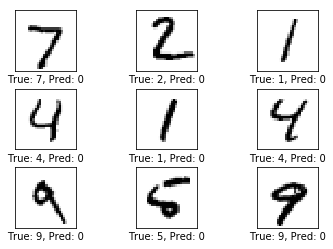

In [34]:
plot_example_errors()

## Performance 1 itération d'optimisation

Déjà après une seule itération d'optimisation, le modèle a augmenté sa précision sur l'ensemble de test à 40,7% contre 9,8%. Cela signifie qu'il classe mal les images environ 6 fois sur 10, comme démontré sur quelques exemples ci-dessous.

In [35]:
optimize(num_iterations=1)

In [36]:
print_accuracy()

Accuracy on test-set: 17.2%


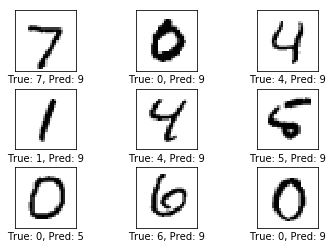

In [37]:
plot_example_errors()

Les poids peuvent également être tracés comme indiqué ci-dessous. Les poids positifs sont en rouge et les poids négatifs en bleu. Ces poids peuvent être intuitivement compris comme des filtres d'image.

Par exemple, les poids utilisés pour déterminer si une image montre un chiffre à zéro ont une réaction positive (rouge) à une image de cercle, et ont une réaction négative (bleu) aux images avec un contenu au centre du cercle.

De même, les poids utilisés pour déterminer si une image affiche un chiffre réagissent positivement (en rouge) à une ligne verticale au centre de l'image et réagissent négativement (en bleu) aux images dont le contenu entoure cette ligne.

Notez que les poids ressemblent principalement aux chiffres qu'ils sont censés reconnaître. En effet, une seule itération d'optimisation a été effectuée, de sorte que les poids ne sont formés que sur 100 images. Après s'être entraînés sur plusieurs milliers d'images, les poids deviennent plus difficiles à interpréter car ils doivent reconnaître de nombreuses variantes de la façon dont les chiffres peuvent être écrits.

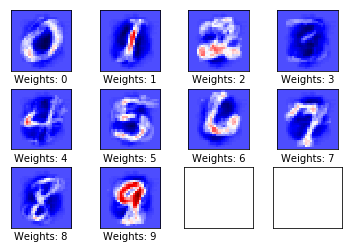

In [38]:
plot_weights()

## Performance après 10 itérations d'optimisations

In [39]:
# Nous avons déjà effectué 1 itération.
optimize(num_iterations=9)

In [40]:
print_accuracy()

Accuracy on test-set: 74.5%


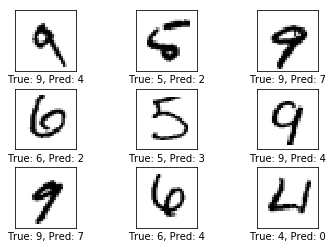

In [41]:
plot_example_errors()

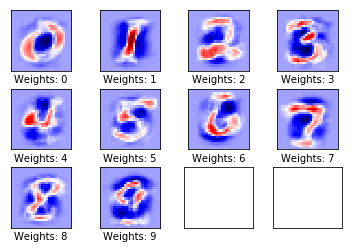

In [42]:
plot_weights()

## Performances après 1000 itérations d'optimisation

Après 1000 itérations d'optimisation, le modèle ne fait que classer à tort environ une image sur dix. Comme démontré ci-dessous, certaines des erreurs de classification sont justifiées car les images sont très difficiles à déterminer avec certitude même pour les humains, alors que d'autres sont assez évidentes et auraient dû être classées correctement par un bon modèle. Mais ce modèle simple ne peut pas atteindre de bien meilleures performances et des modèles plus complexes sont donc nécessaires.

In [43]:
# Nous avons déjà effectué 10 itérations
optimize(num_iterations=990)

In [44]:
print_accuracy()

Accuracy on test-set: 91.5%


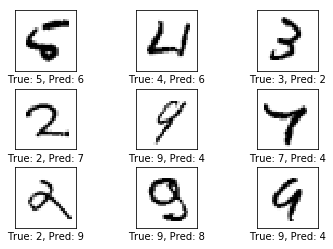

In [45]:
plot_example_errors()

Le modèle a maintenant été formé pour 1000 itérations d'optimisation, chaque itération utilisant 100 images de l'ensemble d'apprentissage. En raison de la grande variété des images, les poids sont devenus difficiles à interpréter et nous pouvons douter que le modèle comprenne vraiment comment les chiffres sont composés à partir des lignes, ou si le modèle vient de mémoriser de nombreuses variations de pixels.

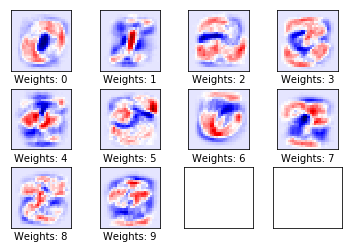

In [46]:
plot_weights()

Nous pouvons également imprimer et tracer la soi-disant matrice de confusion qui nous permet de voir plus de détails sur les erreurs de classification. Par exemple, il montre que les images représentant réellement un 5 ont parfois été mal classées comme tous les autres chiffres possibles, mais la plupart du temps soit 3, 6 ou 8.

[[ 958    0    3    2    0    2   11    1    3    0]
 [   0 1104    4    3    0    1    4    2   17    0]
 [   9    7  916   19   11    0   16   11   40    3]
 [   2    0   20  933    1   13    4   13   21    3]
 [   1    1    6    2  930    0   13    2   12   15]
 [  11    2    7   61   15  713   24    9   45    5]
 [   7    3    3    3   11    5  921    1    4    0]
 [   3    7   29    6   10    0    0  958    4   11]
 [   8    3    6   26    9   14   14   10  884    0]
 [  12    4    3   10   82    4    0   40   24  830]]


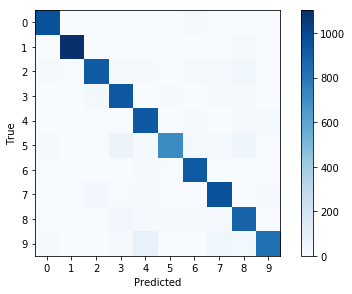

In [47]:
print_confusion_matrix()

Nous avons fini d'utiliser TensorFlow, donc nous fermons la session pour libérer ses ressources.

In [48]:
# Ceci a été commenté au cas où vous voudriez modifier 
# et expérimenter avec le Notebook sans avoir à le redémarrer.
# session.close ()

-## Des exercices

Voici quelques suggestions d'exercices qui pourraient vous aider à améliorer vos compétences avec TensorFlow. Il est important d'acquérir une expérience pratique avec TensorFlow pour apprendre à l'utiliser correctement.

Vous voudrez peut-être sauvegarder ce Notebook avant de faire des changements.

* Modifier le taux d'apprentissage pour l'optimiseur.
* Remplacez l'optimiseur par ex. `AdagradOptimizer` ou` AdamOptimizer`.
* Modifier la taille du lot par ex. 1 ou 1000.
* Comment ces changements affectent-ils la performance?
* Pensez-vous que ces changements auront le même effet (le cas échéant) sur d'autres problèmes de classification et des modèles mathématiques?
* Obtenez-vous exactement les mêmes résultats si vous exécutez le Notebook plusieurs fois sans changer aucun paramètre? Pourquoi ou pourquoi pas?
* Changer la fonction `plot_example_errors ()` de sorte qu'il imprime également les valeurs `logits` et` y_pred` pour les exemples mal classés.
* Utilisez `sparse_softmax_cross_entropy_with_logits` au lieu de` softmax_cross_entropy_with_logits`. Cela peut nécessiter plusieurs changements à plusieurs endroits dans le code source. Discutez des avantages et des inconvénients de l'utilisation des deux méthodes.
* Refaire le programme vous-même sans trop regarder ce code source.
* Expliquez à un ami comment le programme fonctionne.

-Copyright (c) 2016 par [Magnus Erik Hvass Pedersen] (http://www.hvass-labs.org/)

La permission est par la présente accordée à toute personne obtenant une copie de ce logiciel et des fichiers de documentation associés (le «Logiciel»), de traiter le Logiciel sans restriction, y compris sans limitation les droits d'utilisation, de copie, de modification, de fusion , publier, distribuer, sous-licencier et / ou vendre des copies du Logiciel et permettre aux personnes auxquelles le Logiciel est fourni de le faire, sous réserve des conditions suivantes:

L'avis de copyright ci-dessus et cet avis d'autorisation doivent être inclus dans toutes les copies ou parties substantielles du logiciel.

LE LOGICIEL EST FOURNI «EN L'ÉTAT», SANS GARANTIE D'AUCUNE SORTE, EXPRESSE OU IMPLICITE, Y COMPRIS, MAIS SANS S'Y LIMITER, LES GARANTIES DE QUALITÉ MARCHANDE, D'ADÉQUATION À UN USAGE PARTICULIER ET DE NON-CONTREFAÇON. EN AUCUN CAS LES AUTEURS OU LES DÉTENTEURS DE COPYRIGHT NE POURRONT ÊTRE TENUS RESPONSABLES DE TOUTE RÉCLAMATION, DOMMAGE OU AUTRE RESPONSABILITÉ, QUE CE SOIT DANS UNE ACTION DE CONTRAT, DÉLICTUELLE OU AUTRE, DÉCOULANT DE OU EN RELATION AVEC LE LOGICIEL OU L'UTILISATION OU AUTRES TRANSACTIONS LOGICIEL.
